In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.viewer.mpl import drawModel1D

In [2]:
# Clean & Pre-process
def clean_and_process_data(filepath):
    df = pd.read_csv(filepath)
    
    def process_row(row):
        measurements = row[['m1', 'm2', 'm3', 'm4']]
        valid_measurements = measurements[measurements >= 0]
        # If less than 3 measurements are valid, return None
        if len(valid_measurements) < 3:
            return None
        
        mean = valid_measurements.mean()
        std_dev = valid_measurements.std()
        return pd.Series([mean, std_dev], index=['mean', 'std_dev'])
    
    df[['mean', 'std_dev']] = df.apply(process_row, axis=1)
    df.dropna(inplace=True)
    return df

In [3]:
df = clean_and_process_data('./input_position_2.csv')

In [4]:
mn2 = np.array(df['p'])
ab2 = np.array(df['c'])
rho = np.array(df['mean'])

In [5]:
# Initialize the forward model with 6 layers
nlay = 6
f = pg.core.DC1dModelling(nlay, ab2, mn2)
paraDepth = max(ab2) / 2.
f.region(0).setStartValue(paraDepth / nlay)

In [6]:
# Apparent Resistivity
rhoa = (np.pi / (8 * mn2)) * (ab2**2 - mn2**2) * rho

In [7]:
# Set inversion parameters
transThk = pg.trans.TransLog()
transRho = pg.trans.TransLogLU(1, 1000)
transRhoa = pg.trans.TransLog()
f.region(0).setTransModel(transThk)
f.region(1).setTransModel(transRho)
paraDepth = max(ab2) / 3.
f.region(0).setStartValue(paraDepth / nlay / 2)
f.region(1).setStartValue(np.median(rhoa))

In [8]:
# Configure inversion
inv = pg.core.Inversion(rhoa, f, transRhoa, True)
inv.setRelativeError(0.002)
inv.setLambda(100)
inv.setMarquardtScheme(0.8)
model = f.createStartVector()
inv.setModel(model)
model = inv.run()
res, thk = model[nlay-1:nlay*2-1], model[0:nlay-1]

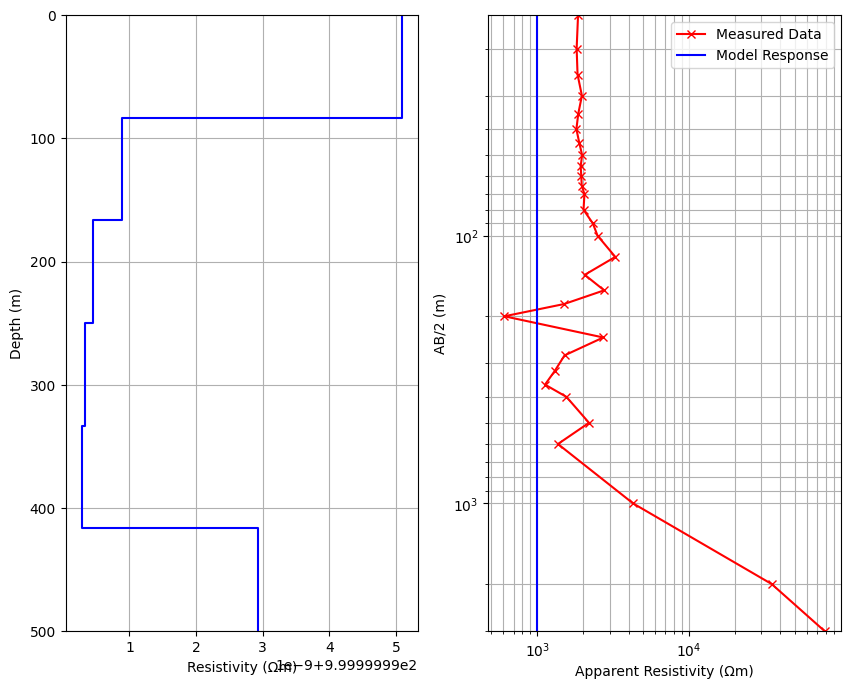

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 8))
drawModel1D(ax[0], thk, res, color='b')
ax[0].grid(True, which='both')
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('Resistivity (Ωm)')
ax[1].loglog(rhoa, ab2, 'rx-', label='Measured Data')
ax[1].loglog(inv.response(), ab2, 'b-', label='Model Response')
ax[1].set_ylim((max(ab2), min(ab2)))
ax[1].grid(True, which='both')
ax[1].set_xlabel('Apparent Resistivity (Ωm)')
ax[1].set_ylabel('AB/2 (m)')
ax[1].legend(loc='best')
plt.show()